In [1]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
from matplotlib import cm
from keras.datasets.cifar10 import load_data

import random
import numpy as np

2024-03-16 18:00:28.198088: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 18:00:28.198192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 18:00:28.337091: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def DataLoad(subset=None):
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  
  if subset is not None:
    train_length = int(len(x_train) * subset)
    x_train = x_train[:train_length]
    y_train = y_train[:train_length]
    
    test_length = int(len(x_test) * subset)
    x_test = x_test[:test_length]
    y_test = y_test[:test_length]
  
  val_split = 0.2
  val_length = int(len(x_train) * val_split)
  x_val = x_train[:val_length]
  y_val = y_train[:val_length]
  
  x_train = x_train[val_length:]
  y_train = y_train[val_length:]
  
  return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = DataLoad()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [3]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((40000, 32, 32, 3),
 (40000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 (10000, 32, 32, 3),
 (10000, 1))

In [4]:
# Labels
lables = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

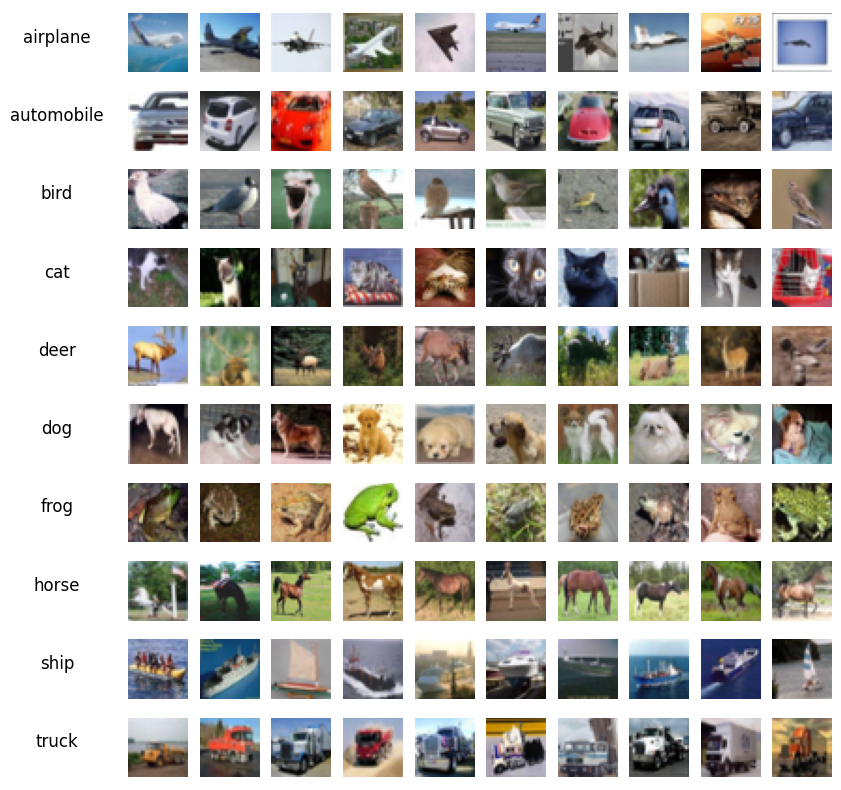

In [5]:
# Plot the 10 images from each label
fig, axes = plt.subplots(10, 11, figsize=(10, 10))

for i in range(10):
    axes[i, 0].text(0, 0.5, lables[i], fontsize=12, ha='center')
    axes[i, 0].axis('off')
    for j in range(1, 11):  # Modify the range to start from 1 instead of 0
        index = random.choice(np.where(y_train == i)[0])
        axes[i, j].imshow(x_train[index])
        axes[i, j].axis('off')

In [6]:
from keras import layers, models, optimizers, ops

# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
@keras.saving.register_keras_serializable(package="PixelConvLayer")
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = ops.shape(self.conv.kernel)
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0
            
    def get_config(self):
        base_config = super().get_config()
        config = {
            "mask_type": keras.saving.serialize_keras_object(self.mask_type)
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        sublayer_config = config.pop("mask_type")
        sublayer = keras.saving.deserialize_keras_object(sublayer_config)
        return cls(sublayer, **config)

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
@keras.saving.register_keras_serializable(package="ResidualBlock")
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
    
    def get_config(self):
        base_config = super().get_config()
        config = {
            "filters": keras.saving.serialize_keras_object(self.filters)
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        sublayer_config = config.pop("filters")
        sublayer = keras.saving.deserialize_keras_object(sublayer_config)
        return cls(sublayer, **config)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])

input_shape = (32, 32, 3)
@keras.saving.register_keras_serializable(package="PixelCNNModel")
class PixelCNNModel(keras.Model):
    def __init__(self, input_shape=(32, 32, 3),
                 residual_blocks_count=2,
                 pixel_conv_layers_count=1,
                 **kwargs):
        super().__init__(**kwargs)
        self.input_shape = input_shape
        self.residual_blocks_count = residual_blocks_count
        self.pixel_conv_layers_count = pixel_conv_layers_count
        
        self.inputs = keras.Input(shape=self.input_shape, batch_size=32)

        self.pixel_conv_layer = PixelConvLayer(
            mask_type="A", filters=64, kernel_size=7, activation="relu", padding="same"
        )

        self.residual_blocks = [ResidualBlock(filters=64) for _ in range(residual_blocks_count)]

        self.pixel_conv_layers = [
            PixelConvLayer(
                mask_type="B", filters=64, kernel_size=1, strides=1, activation="relu", padding="same"
            ) for _ in range(pixel_conv_layers_count)
        ]

        self.conv_output = keras.layers.Conv2D(
            filters=3, kernel_size=1, strides=1, padding="valid"
        )
    def compute_output_shape(self, input_shape):
        return 

    def call(self, inputs):
        x = self.pixel_conv_layer(inputs)
        for residual_block in self.residual_blocks:
            x = residual_block(x)
        for pixel_conv_layer in self.pixel_conv_layers:
            x = pixel_conv_layer(x)
        return self.conv_output(x)
    
    def model(self):
        return keras.Model(inputs=self.inputs, outputs=self.call(self.inputs))

    def get_config(self):
        base_config = super().get_config()
        config = {
            "input_shape": keras.saving.serialize_keras_object(self.input_shape),
            "residual_blocks_count": keras.saving.serialize_keras_object(self.residual_blocks_count),
            "pixel_conv_layers_count": keras.saving.serialize_keras_object(self.pixel_conv_layers_count),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        # add all parameters to the config
        for key in config:
            config[key] = keras.saving.deserialize_keras_object(config[key])
        
        return cls(**config)

In [7]:
# First Variant
pixel_cnn_1 = PixelCNNModel(input_shape, 2, 1)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn_1.compile(optimizer=adam, loss="binary_crossentropy")

pixel_cnn_1.model().summary()

# Second Variant
pixel_cnn_2 = PixelCNNModel(input_shape, 3, 2)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn_2.compile(optimizer=adam, loss="binary_crossentropy")

pixel_cnn_2.model().summary()

# Third Variant
pixel_cnn_3 = PixelCNNModel(input_shape, 5, 3)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn_3.compile(optimizer=adam, loss="binary_crossentropy")

pixel_cnn_3.model().summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (32, 32, 32, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_conv_layer                │ (32, 32, 32, 64)       │         9,472 │
│ (PixelConvLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ (32, 32, 32, 64)       │        24,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (32, 32, 32, 64)       │        24,736 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_conv_layer_3              │ (32, 32, 32, 64)       │         4,160 │
│ (PixelConvLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 32, 32, 3)        │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,299 (247.26 KB)

 Trainable params: 63,299 (247.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (32, 32, 32, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_conv_layer_4              │ (32, 32, 32, 64)       │         9,472 │
│ (PixelConvLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (32, 32, 32, 64)       │        24,736 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ (32, 32, 32, 64)       │        24,736 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ (32, 32, 32, 64)       │        24,736 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_conv_layer_8              │ (32, 32, 32, 64)       │         4,160 │
│ (PixelConvLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_conv_layer_9              │ (32, 32, 32, 64)       │         4,160 │
│ (PixelConvLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (32, 32, 32, 3)        │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,195 (360.14 KB)

 Trainable params: 92,195 (360.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (32, 32, 32, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_conv_layer_10             │ (32, 32, 32, 64)       │         9,472 │
│ (PixelConvLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_5                │ (32, 32, 32, 64)       │        24,736 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_6                │ (32, 32, 32, 64)       │        24,736 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_7                │ (32, 32, 32, 64)       │        24,736 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_8                │ (32, 32, 32, 64)       │        24,736 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_9                │ (32, 32, 32, 64)       │        24,736 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_conv_layer_16             │ (32, 32, 32, 64)       │         4,160 │
│ (PixelConvLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_conv_layer_17             │ (32, 32, 32, 64)       │         4,160 │
│ (PixelConvLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_conv_layer_18             │ (32, 32, 32, 64)       │         4,160 │
│ (PixelConvLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (32, 32, 32, 3)        │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,827 (569.64 KB)

 Trainable params: 145,827 (569.64 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Concatenate all the train images
data = np.concatenate([x_train, x_val, x_test], axis=0)

data = data / 255.0

data.shape

(60000, 32, 32, 3)

In [9]:
# Train the model
pixel_cnn_1.fit(data, data, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
 13/422 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.8725

I0000 00:00:1710612063.911002     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - loss: 0.7086 - val_loss: 0.5627
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.5627 - val_loss: 0.5602
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.5600 - val_loss: 0.5590
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.5604 - val_loss: 0.5649
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.5583 - val_loss: 0.5570
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.5573 - val_loss: 0.5573
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.5583 - val_loss: 0.5569
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.5568 - val_loss: 0.5640
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.5575 - val_loss: 0.5562
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.5579 - val_loss: 0.5574


In [10]:
pixel_cnn_2.fit(data, data, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 1.0992 - val_loss: 0.5653
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.5651 - val_loss: 0.5627
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.5625 - val_loss: 0.5591
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.5603 - val_loss: 0.5585
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.5598 - val_loss: 0.5591
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.5583 - val_loss: 0.5568
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.5579 - val_loss: 0.5565
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.5574 - val_loss: 0.5602
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.5594 - val_loss: 0.5562
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.5570 - val_loss: 0.5571


In [11]:
pixel_cnn_3.fit(data, data, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - loss: 5.2939 - val_loss: 5.2400
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 5.2313 - val_loss: 5.2385
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 5.0623 - val_loss: 3.0242
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 3.0250 - val_loss: 3.0338
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 3.0216 - val_loss: 3.0166
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 3.0146 - val_loss: 3.0137
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 3.0083 - val_loss: 3.0144
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 3.0130 - val_loss: 3.0136
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 3.0142 - val_loss: 3.0141
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 3.0096 - val_loss: 3.0188


In [12]:
# Save the model with accuracy
path = ''

pixel_cnn_1.save(path + 'pixel_cnn_1.keras')

pixel_cnn_2.save(path + 'pixel_cnn_2.keras')

pixel_cnn_3.save(path + 'pixel_cnn_3.keras')

In [13]:
pixel_cnn_1 = keras.saving.load_model(path + 'pixel_cnn_1.keras')
pixel_cnn_2 = keras.saving.load_model(path + 'pixel_cnn_2.keras')
pixel_cnn_3 = keras.saving.load_model(path + 'pixel_cnn_3.keras')

In [53]:
import numpy as np
from tqdm import tqdm

def generate_fake_samples(model, x_test, random_idx=0, samples=2):
    def deprocess_image(x):
        # Stack the image back to 3 channels
        x = x.reshape((32, 32, 3))
        # Ensure the pixel values are between 0 and 1
        x = np.clip(x, 0, 1)
        # Convert to image
        x = (x * 255).astype(np.uint8)
        return x

    # convert x_test to float32
    x_test = x_test.astype(np.float32)

    _x_test = x_test / 255.0

    # Step 1: Generate Real Samples
    # Get any random sample from the test set
    real_samples = _x_test[random_idx:random_idx + samples]

    # Step 2: Generate Fake Samples
    num_fake_samples = len(real_samples)  # Generate the same number of fake samples as real samples

    fake_samples = []

    for sample_idx in range(num_fake_samples):
        pixels = real_samples[sample_idx].copy()
        for row in tqdm(range(32)):
            for col in range(32):
                for channel in range(3):
                    # Use the model to predict the pixel values.
                    # Use real samples to predict the fake samples
                    probs = model.predict(real_samples, verbose=0)[sample_idx, row, col, channel]
                    # Ensure the pixel values are between 0 and 1
                    probs = np.clip(probs, 0, 1)
                    # Update the pixel values in the image frame.
                    pixels[row, col, channel] = probs
                    
        fake_samples.append(deprocess_image(pixels))

    # Convert the list of fake samples to a NumPy array
    fake_samples = np.array(fake_samples)

    # Deprocess the real samples
    real_samples_deprocessed = [deprocess_image(sample) for sample in real_samples]

    return real_samples_deprocessed, fake_samples

random_idx = np.random.choice(range(len(x_test)))
# Example usage:
real_samples_deprocessed, fake_samples_1 = generate_fake_samples(pixel_cnn_1, x_test, random_idx)
real_samples_deprocessed, fake_samples_2 = generate_fake_samples(pixel_cnn_2, x_test, random_idx)
real_samples_deprocessed, fake_samples_3 = generate_fake_samples(pixel_cnn_3, x_test, random_idx)
print("Shape of real samples:", real_samples_deprocessed[0].shape)
print("Shape of fake samples:", fake_samples_1.shape)

100%|██████████| 32/32 [03:08<00:00,  5.89s/it]

Shape of real samples: (32, 32, 3)
Shape of fake samples: (2, 32, 32, 3)


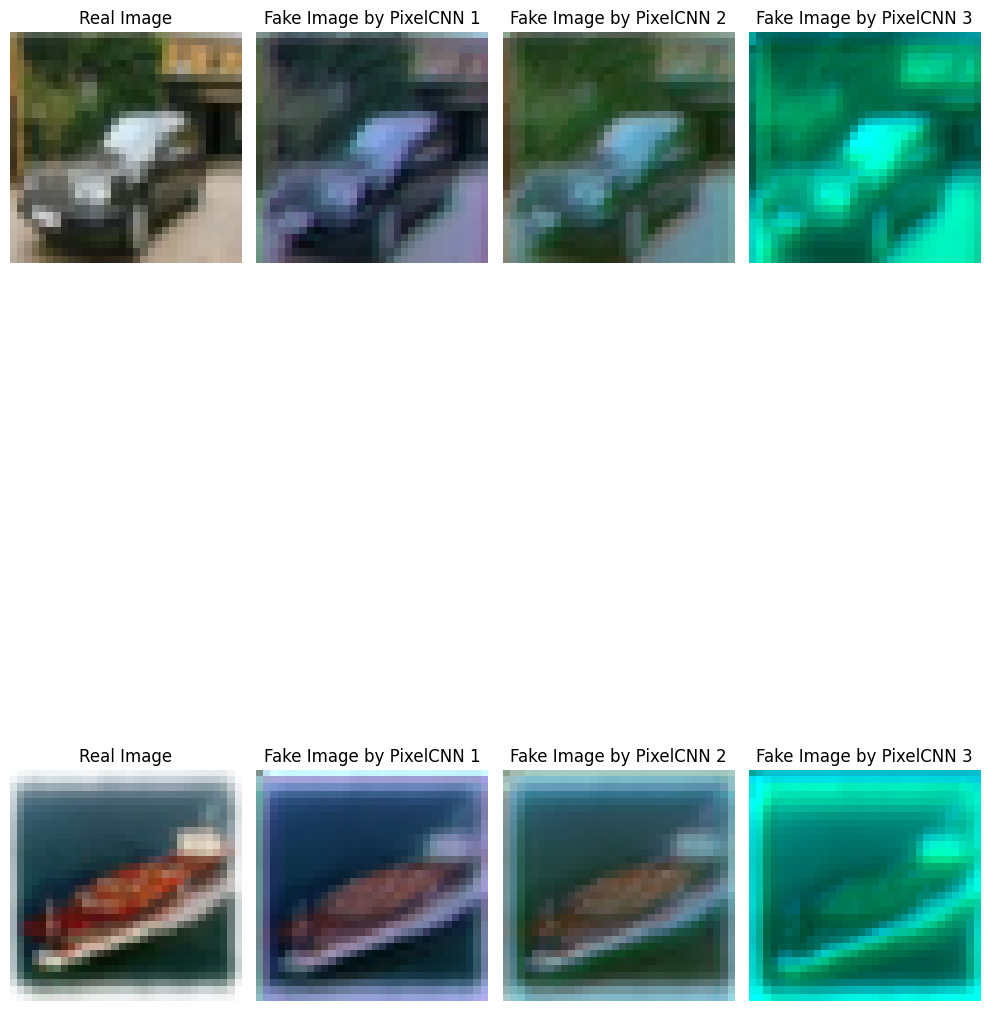

In [54]:
import matplotlib.pyplot as plt

# Number of pairs of real and fake samples to plot
num_pairs = min(len(real_samples_deprocessed), len(fake_samples_1))

# Plot real vs fake samples
fig, axes = plt.subplots(num_pairs, 4, figsize=(10, 10*num_pairs))
if num_pairs < 2:
    axes = axes.reshape(1, 4)  # Reshape axes to have 1 row

for i in range(num_pairs):
    axes[i, 0].imshow(real_samples_deprocessed[i].astype(np.uint8))
    axes[i, 0].set_title("Real Image")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(fake_samples_1[i].astype(np.uint8))
    axes[i, 1].set_title("Fake Image by PixelCNN 1")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(fake_samples_2[i].astype(np.uint8))
    axes[i, 2].set_title("Fake Image by PixelCNN 2")
    axes[i, 2].axis("off")
    axes[i, 3].imshow(fake_samples_3[i].astype(np.uint8))
    axes[i, 3].set_title("Fake Image by PixelCNN 3")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()

In [55]:
def log_likelihood_loss(y_true, y_pred): # define the negative log likelihood loss
  
  # Flatten the true and predicted pixel values
  y_true_flat = tf.reshape(y_true, shape=(-1,))
  #TypeError: Cannot convert 1.0 to EagerTensor of dtype uint8
  y_pred_flat = tf.clip_by_value(y_pred, clip_value_min=1e-7, clip_value_max=1.0)
  y_pred_flat = tf.reshape(y_pred_flat, shape=(-1,))

  # Compute the negative log likelihood
  neg_log_likelihood = -tf.reduce_mean(tf.math.log(y_pred_flat) * y_true_flat)

  return neg_log_likelihood

In [56]:
# frechet inception distance
from scipy import linalg
def calculateFID(y_true,y_pred, input_shape): # define the FID metric
    model = keras.applications.MobileNetV2(include_top=False, pooling='avg', input_shape=input_shape,weights='imagenet') # load the pre-trained model
    
    real = keras.applications.mobilenet_v2.preprocess_input(y_true) # preprocess the real and generated images
    generated = keras.applications.mobilenet_v2.preprocess_input(y_pred)
    
    real = model.predict(real)  # get the features from the pre-trained model
    generated = model.predict(generated)
    
    mu,sigma = np.mean(real, axis=0), np.cov(real, rowvar=False) # calculate the mean and covariance of the real and generated images
    mu2, sigma2 = np.mean(generated, axis=0), np.cov(generated, rowvar=False)
    
    mu_difference = mu - mu2
    sigma_epsilon = linalg.sqrtm(sigma.dot(sigma2)).real
    
    fid = np.real(mu_difference.dot(mu_difference) + np.trace(sigma + sigma2 - 2 * sigma_epsilon)) # calculate the FID
    
    return fid

In [57]:
real_samples_deprocessed = np.array(real_samples_deprocessed)
real_samples_deprocessed.shape, fake_samples_1.shape

((2, 32, 32, 3), (2, 32, 32, 3))

In [58]:
num_pairs = min(len(real_samples_deprocessed), len(fake_samples_1))

# convert real samples to float32
_real_samples = real_samples_deprocessed.astype(np.float32)
# convert fake samples to float32
_fake_samples_1 = fake_samples_1.astype(np.float32)
_fake_samples_2 = fake_samples_2.astype(np.float32)
_fake_samples_3 = fake_samples_3.astype(np.float32)


# calculate the log likelihood loss
loglikelihood_1 = log_likelihood_loss(_real_samples, _fake_samples_1)
loglikelihood_2 = log_likelihood_loss(_real_samples, _fake_samples_2)
loglikelihood_3 = log_likelihood_loss(_real_samples, _fake_samples_3)

# calculate the FID
fid_1 = calculateFID(_real_samples, _fake_samples_1, (32, 32, 3))
fid_2 = calculateFID(_real_samples, _fake_samples_1, (32, 32, 3))
fid_3 = calculateFID(_real_samples, _fake_samples_1, (32, 32, 3))

print(f"Log Likelihood Loss:")
print(f"PixelCNN 1: {loglikelihood_1}")
print(f"PixelCNN 2: {loglikelihood_2}")
print(f"PixelCNN 3: {loglikelihood_3}")

print(f"FID :")
print(f"PixelCNN 1: {fid_1}")
print(f"PixelCNN 2: {fid_2}")
print(f"PixelCNN 3: {fid_3}")
print("\n")

/tmp/ipykernel_34/1739098747.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = keras.applications.MobileNetV2(include_top=False, pooling='avg', input_shape=input_shape,weights='imagenet') # load the pre-trained model


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Log Likelihood Loss:
PixelCNN 1: 0.06820809096097946
PixelCNN 2: -0.0
PixelCNN 3: 544.4107055664062
FID :
PixelCNN 1: 8.577514083841265
PixelCNN 2: 0.1675862948117253
PixelCNN 3: 1.5005139656391207e-06


